In [2]:
import os

if "src" not in os.listdir():
    os.chdir("../../../")

import json
import math

import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from dateutil import parser
import pandas as pd
# from pytz import timezone
import pickle
import plotly.graph_objects as go

import pandas_market_calendars as mcal
from keras.models import load_model

from src.lib.alpaca_historical import AlpacaData
from src.lib.alpaca_paper import AlpacaTrader
from src.lib.activations import negative_softmax
from src.lib.price_history import transform_price_history, PriceHistory
from src.lib.stock_dataset import read_stock_dataset
from src.lib.util import makedir_to
%load_ext autoreload
%autoreload 2

In [3]:
path = "results/4_lstm_long/"
keys = "alpaca_config.json"

In [4]:
api_data = AlpacaData(keys)

model = load_model(
    os.path.join(path, "model.h5"),
    custom_objects={
        "negative_softmax": negative_softmax
    }
)

with open(os.path.join(path, "config.json"), "r") as f:
    config = json.load(f)

n_time_steps = config["n_time_steps"]
symbols = config["symbols"]
target_column = config["target_column"]

with open(os.path.join(path, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)

for symbol in symbols:
    api_data.update_saved_data(symbol)

dataset = read_stock_dataset(symbols, target_column, n_time_steps)
dataset = dataset.apply_standard_scaler(scaler)

with open(os.path.join(path, "trade_log.txt"), "r") as f:
    trade_log = f.readlines()

equity_history = np.array([
    float(line.split(",")[-1].strip())
    for line in trade_log
])
equity_history /= equity_history[0]

log_index = np.array([
    parser.parse(line.split(",")[0].strip()).replace(second=0, microsecond=0)
    for line in trade_log
])



2021-09-23 18:54:00+00:00:  99%|█████████▉| 99.17/100 [00:00<00:00, 691.95it/s]
2021-09-23 18:54:00+00:00:  99%|█████████▉| 99.1/100 [00:00<00:00, 805.45it/s]


In [5]:


equity = pd.Series(equity_history, index=log_index, name="equity")
time_index = [
    time
    for time in equity.index
    if time in dataset.X.index
]
equity = equity[time_index]

live_preds = np.zeros((len(trade_log), len(symbols)))
for i, line in enumerate(trade_log):
    parts = line.split(",")
    string = ",".join([parts[1], parts[2]]).replace("'", "\"")
    holding_dict = json.loads(string)
    for j, symbol in enumerate(symbols):
        live_preds[i, j] = holding_dict[symbol]
live_preds = live_preds[range(len(equity))]

start_ind = dataset.X.index.get_loc(equity.index[0])
end_ind = dataset.X.index.get_loc(equity.index[-1])+1
int_index = [
    v
    for k, v in enumerate(range(start_ind, end_ind))
    if equity.index[k] in dataset.X.index
]

X, y = dataset.get_batch(len(int_index), int_index, shuffle=False, replace=False)

In [7]:
# change_diff = np.diff(equity)/equity[:-1] - np.diff(rets_live_preds)/rets_live_preds[:-1]
# plt.plot(change_diff)
# plt.show()
# print(change_diff.mean())
# print(change_diff.std())
# print(abs(change_diff.std()/change_diff.mean()))

In [8]:
# adj_rets = np.exp(((np.log(live_preds*y + 1)).sum(axis=-1)[:-1] + np.log(1+change_diff)).cumsum())
# adj_rets = ((live_preds*y + 1).prod(-1) * (1 + change_diff[:len(change_diff)].mean())).cumprod()

In [9]:
def read_quotes(symbol, time_index, delay=timedelta(seconds=4)):
    df = pd.read_csv(f"data/{symbol}/{symbol}_quotes.csv", index_col="time")
    df.index = pd.to_datetime(df.index) - delay
    time_series = pd.Series(df.index.floor("1T")).drop_duplicates()
    minute_quotes = df.iloc[time_series.index]
    minute_quotes.index = minute_quotes.index.floor("1T")
    quotes = minute_quotes.reindex(time_index)
    return quotes


In [10]:
quotes = {
    symbol: read_quotes(symbol, time_index, delay=timedelta(seconds=4))
    for symbol in symbols
}

In [52]:
quote_y  = np.zeros_like(y[:-1])
for i in range(len(symbols)):
    bids = quotes[symbols[i]]["bid_price"].to_numpy()[1:]
    asks = quotes[symbols[i]]["ask_price"].to_numpy()[:-1]
    quote_y[:, i] = ((bids/asks-1) + y[:-1][:, i])/2

In [53]:
preds = model.predict(X)
rets = np.exp((np.log(preds*y + 1)).sum(axis=-1).cumsum())
rets_live_preds = np.exp((np.log(live_preds*y + 1)).sum(axis=-1).cumsum())
ba_rets = np.exp((np.log(live_preds[:-1]*quote_y + 1)).sum(axis=-1).cumsum())

In [49]:
holdings = {
    symbol: 0
    for symbol in symbols
}
cash = 100000
sim_equity = [cash]
for i, pred in enumerate(live_preds):

    this_equity = cash
    for symbol in symbols:
        bid = quotes[symbol].iloc[i]["bid_price"]
        ask = quotes[symbol].iloc[i]["ask_price"]
        avg = (bid + ask)/2
        this_equity += avg * holdings[symbol]
    sim_equity.append(this_equity)

    for j, symbol in enumerate(symbols):
        bid = quotes[symbol].iloc[i]["bid_price"]
        ask = quotes[symbol].iloc[i]["ask_price"]
        avg = (bid + ask)/2

        p_hold = holdings[symbol] * avg / sim_equity[-1]

        p_hold_delta = pred[j] - p_hold

        share_delta = math.floor(p_hold_delta * sim_equity[-1] / avg)

        trade_price = ask if share_delta > 0 else bid

        trade_cost = share_delta * trade_price

        cash -= trade_cost
        holdings[symbol] += share_delta
    
sim_equity = np.array(sim_equity)[1:]
sim_equity /= sim_equity[0]
sim_equity.shape


(373,)

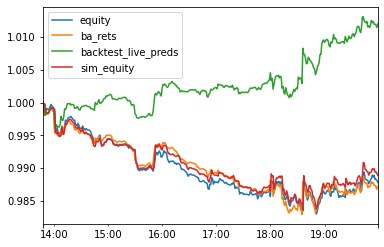

In [54]:
performance = pd.DataFrame({
    "equity": equity[:-1],
    "ba_rets": ba_rets,
    
    "backtest_live_preds": rets_live_preds[:-1],
    "sim_equity": sim_equity[:-1]
}, index=time_index[:-1])
performance.plot()
plt.show()